Found 14 CSV files
Original data sum: 0.9999999391962712
Processed file: gradientdata/saliency_results_fart_AutoEncodeEasy_Partial=True.csv
Original data sum: 0.9999999719206224
Processed file: gradientdata/saliency_results_fart_CountRecallEasy_Partial=False.csv
Original data sum: 1.0000000052154037
Processed file: gradientdata/saliency_results_fart_CountRecallEasy_Partial=True.csv
Original data sum: 0.9999999899882818
Processed file: gradientdata/saliency_results_fart_NavigatorEasy_Partial=False.csv
Original data sum: 0.9999999599240158
Processed file: gradientdata/saliency_results_fart_CartPoleEasy_Partial=True.csv
Original data sum: 1.0000000254251054
Processed file: gradientdata/saliency_results_fart_MineSweeperEasy_Partial=False.csv
Original data sum: 1.0000000548490693
Processed file: gradientdata/saliency_results_fart_NoisyCartPoleEasy_Partial=True.csv
Original data sum: 0.9999999894993317
Processed file: gradientdata/saliency_results_fart_BattleShipEasy_Partial=False.csv
Origin

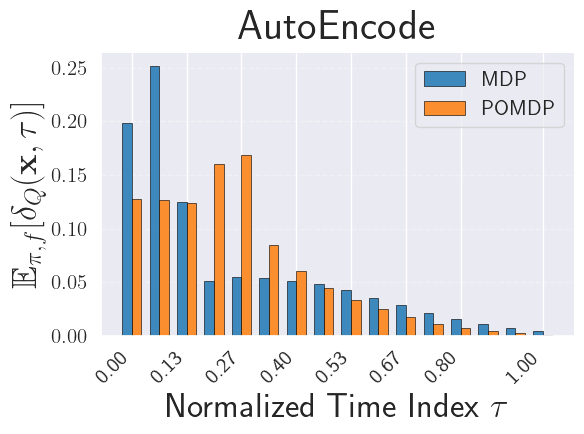

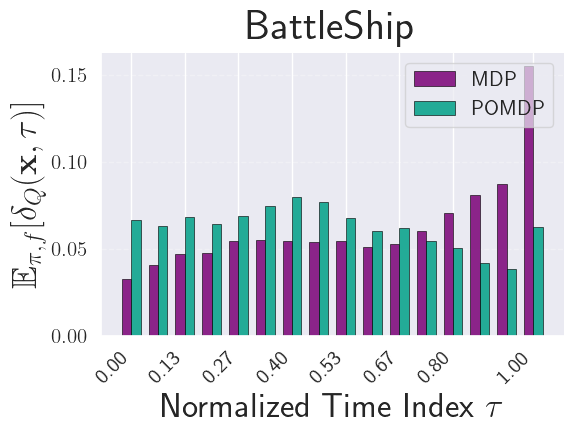

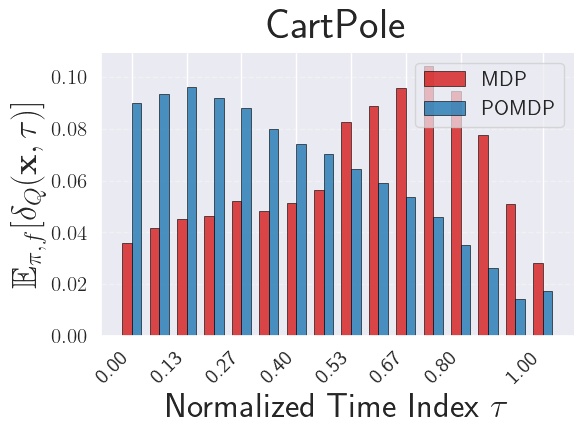

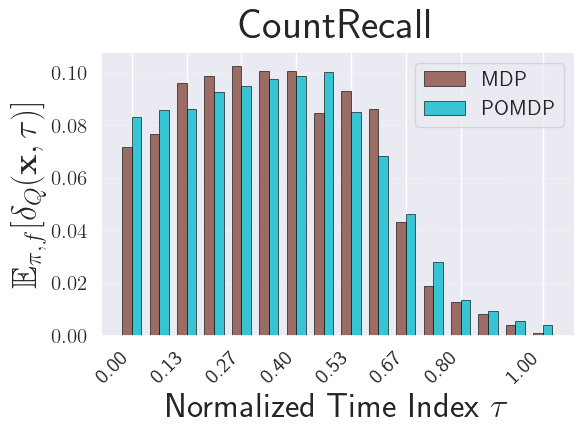

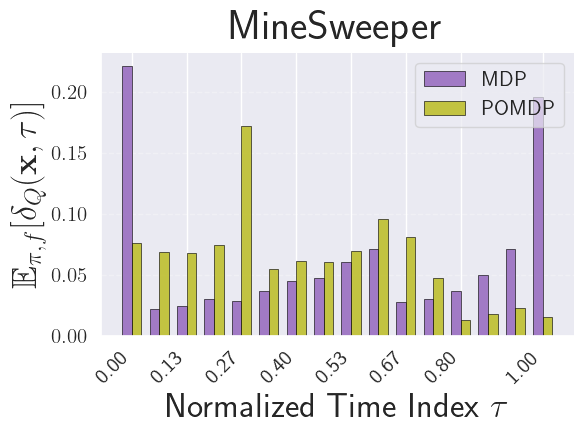

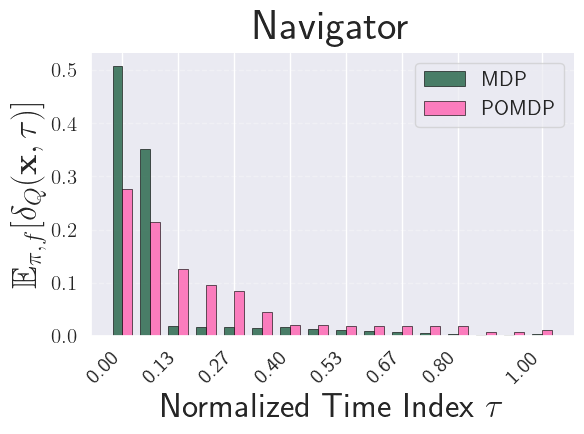

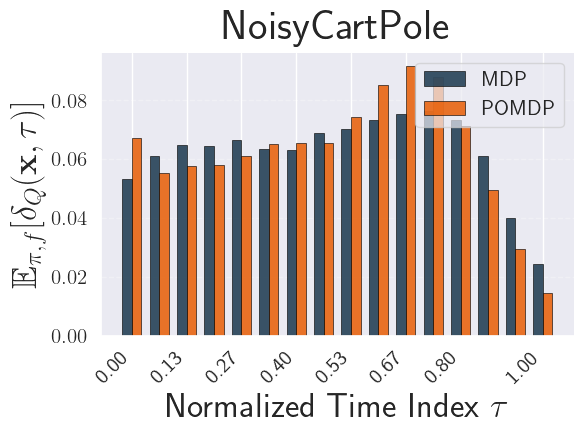

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.gridspec as gridspec

# Set style
plt.style.use('ggplot')
sns.set()
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# Create color themes for different environments
def get_env_colors(env_idx):
    """
    Return the bar colors for MDP and POMDP for each environment.
    Colors are based on seaborn palettes.
    """
    # Define 7 sets of color themes; each set contains colors for MDP and POMDP
    color_themes = [
        # Theme 1: Blue-Orange contrast (high contrast)
        {"mdp": "#1F77B4", "pomdp": "#FF7F0E"},
        # Theme 2: Purple-Green contrast (high discernibility)
        {"mdp": "#7A0177", "pomdp": "#00A087"},
        # Theme 3: Red-Blue contrast (strong contrast)
        {"mdp": "#D62728", "pomdp": "#2C7FB8"},
        # Theme 4: Brown-Cyan contrast (vivid)
        {"mdp": "#8C564B", "pomdp": "#17BECF"},
        # Theme 5: Dark Yellow-Light Purple contrast (modern feel)
        {"mdp": "#9467BD", "pomdp": "#BCBD22"},
        # Theme 6: Dark Green-Bright Pink contrast (vivid contrast)
        {"mdp": "#2D6A4F", "pomdp": "#FF69B4"},
        # Theme 7: Navy Blue-Orange-Red (high saturation)
        {"mdp": "#1A374D", "pomdp": "#E85D04"}
    ]

    # Get the corresponding color theme based on the environment index
    theme_idx = env_idx % len(color_themes)
    return color_themes[theme_idx]

# Search for all CSV files
csv_files = glob.glob("gradientdata/saliency_results_fart_*.csv")
print(f"Found {len(csv_files)} CSV files")

# Function: extract environment and partial observation settings from filename
def extract_info_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.replace('saliency_results_fart_', '').replace('.csv', '').split('_')
    env_name = parts[0]
    partial_obs = parts[1].split('=')[1]
    return env_name, partial_obs

# Aggregate data
file_data = []

for csv_file in csv_files:
    try:
        # Extract environment and partial observation settings
        env_name, partial_obs = extract_info_from_filename(csv_file)

        # Read CSV file
        df = pd.read_csv(csv_file)

        # Get columns that start with "pos_"
        pos_cols = [col for col in df.columns if col.startswith('pos_')]

        # Sort the position columns to ensure the correct order
        pos_cols.sort(key=lambda x: float(x.replace('pos_', '')))

        # Extract position values and labels
        positions_values = [float(col.replace('pos_', '')) for col in pos_cols]
        pos_labels = [f"{pos:.2f}" for pos in positions_values]

        # Get the mean value over seeds for each position
        means = df[pos_cols].mean().values

        # Print original data sum for verification
        print(f"Original data sum: {means.sum()}")

        # Store result
        file_data.append({
            'file': csv_file,
            'env_name': env_name,
            'partial_obs': partial_obs == 'True',  # Convert to boolean
            'display_name': f"{'POMDP' if partial_obs=='True' else 'MDP'}",
            'n_seeds': len(df),
            'positions_values': positions_values,  # Store actual position values
            'pos_labels': pos_labels,
            'means': means
        })

        print(f"Processed file: {csv_file}")

    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")

# Set unified number of data points for all environments to 16
target_data_points = 16
print(f"Set unified number of data points to: {target_data_points}")

# Function: average data points to the target size while preserving the total sum
def average_to_target_size(values, target_size):
    """Average the values array to a target_size-length array while preserving the total sum"""
    if len(values) <= target_size:
        return values  # Return as-is if the original length is less than or equal to the target

    # Record the original total sum
    original_sum = np.sum(values)
    print(f"Original sum: {original_sum}")

    # Calculate how many original data points each bin should contain
    bin_size = len(values) / target_size

    result = []
    for i in range(target_size):
        start_idx = int(i * bin_size)
        end_idx = int((i + 1) * bin_size)
        # Ensure the last bin includes all remaining elements
        if i == target_size - 1:
            end_idx = len(values)
        # Compute the average for this bin
        bin_avg = np.mean(values[start_idx:end_idx])
        result.append(bin_avg)

    result = np.array(result)

    # Adjust the result to preserve the original total sum
    if np.sum(result) > 0:
        result = result * (original_sum / np.sum(result))

    return result

# Average all data to 16 data points
for data in file_data:
    if len(data['means']) != target_data_points:
        # Average the mean data while preserving the total sum
        data['means'] = average_to_target_size(data['means'], target_data_points)
        # Average the position values and labels
        data['positions_values'] = np.linspace(0, 1, target_data_points)
        data['pos_labels'] = [f"{pos:.2f}" for pos in data['positions_values']]

    # Print verification
    print(f"{data['env_name']} - {data['display_name']} after averaging, total sum: {np.sum(data['means']):.6f}")

# Get unique environment names
env_names = sorted(set(data['env_name'] for data in file_data))

# Properties for the bar charts
bar_width = 0.35
alpha = 0.85

# Create separate plots for each environment
for env_idx, env_name in enumerate(env_names):
    # Create a new figure for each environment
    plt.figure(figsize=(6, 4.5))
    ax = plt.gca()

    # Get MDP and POMDP data for the current environment
    env_specific_data = [d for d in file_data if d['env_name'] == env_name]

    # Ensure order: MDP first, then POMDP
    env_specific_data.sort(key=lambda x: x['partial_obs'])

    # Remove the "Easy" suffix from title if present
    plot_title = env_name.replace('Easy', '')

    # Get the color theme for this environment
    env_colors = get_env_colors(env_idx)

    if len(env_specific_data) == 2:
        mdp_data, pomdp_data = env_specific_data

        plot_len = len(mdp_data['means'])  # Should be 16 now
        current_pos_labels_for_ticks = mdp_data['pos_labels']

        x_indices = np.arange(plot_len)

        bars1 = ax.bar(
            x_indices - bar_width/2,
            mdp_data['means'],
            bar_width,
            alpha=alpha,
            color=env_colors["mdp"],
            edgecolor='black',
            linewidth=0.5,
            label='MDP'  # Use plain text, not LaTeX
        )

        bars2 = ax.bar(
            x_indices + bar_width/2,
            pomdp_data['means'],
            bar_width,
            alpha=alpha,
            color=env_colors["pomdp"],
            edgecolor='black',
            linewidth=0.5,
            label='POMDP'  # Use plain text, not LaTeX
        )

        ax.legend(fontsize=15, frameon=True, framealpha=0.7, loc='upper right')

    elif len(env_specific_data) == 1:
        data = env_specific_data[0]
        plot_len = len(data['means'])
        current_pos_labels_for_ticks = data['pos_labels']

        if plot_len > 0:
            x_indices = np.arange(plot_len)
            color = env_colors["pomdp"] if data['partial_obs'] else env_colors["mdp"]

            bars = ax.bar(
                x_indices,
                data['means'],
                bar_width * 1.5,
                alpha=alpha,
                color=color,
                edgecolor='black',
                linewidth=0.5,
                label=data['display_name']
            )
            ax.legend(fontsize=10, frameon=True, framealpha=0.7, loc='upper right')
    else:  # No data for this environment
        plot_len = 0
        current_pos_labels_for_ticks = []

    ax.set_title(plot_title, fontsize=30, pad=10)
    ax.set_ylabel(r'$\mathbb{E}_{\pi, f}[\delta_Q(\mathbf{x}, \tau)]$', fontsize=25)
    ax.set_xlabel(r'Normalized Time Index $\tau$', fontsize=25)  # Changed label since we use indices

    if plot_len > 0:
        n_ticks = min(8, plot_len)
        tick_indices_numeric = np.linspace(0, plot_len - 1, n_ticks, dtype=int)
        ax.set_xticks(tick_indices_numeric)
        ax.set_xticklabels([current_pos_labels_for_ticks[idx] for idx in tick_indices_numeric], rotation=45, ha="right")
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    # Remove the "Easy" suffix from filename if present
    clean_env_name = env_name.replace('Easy', '')
    # plt.savefig(f'fart_{clean_env_name}.pdf', dpi=300, bbox_inches='tight')

    # Show the individual plot
    plt.show()

# Create a summary dataframe including early, mid, and late mean values
summary_df = pd.DataFrame([{
    'env_name': data['env_name'].replace('Easy', ''),  # Remove the "Easy" suffix from summary data
    'model_type': 'POMDP' if data['partial_obs'] else 'MDP',
    'n_seeds': data['n_seeds'],
    'total_sum': np.sum(data['means']),
    'early_mean': np.sum(data['means'][:len(data['means'])//3]) if len(data['means']) >= 3 else np.nan,
    'mid_mean': np.sum(data['means'][len(data['means'])//3:2*len(data['means'])//3]) if len(data['means']) >= 3 else np.nan,
    'late_mean': np.sum(data['means'][2*len(data['means'])//3:]) if len(data['means']) >= 3 else np.nan
} for data in file_data])

# print("\nSummary data:")
# print(summary_df)
# summary_df.to_csv('normalized_saliency_summary.csv', index=False)
# print("Summary data saved to CSV file")

Start aggregating all model data...
Aggregated 42 results covering 14 environment-observation combinations

--- Process complete ---


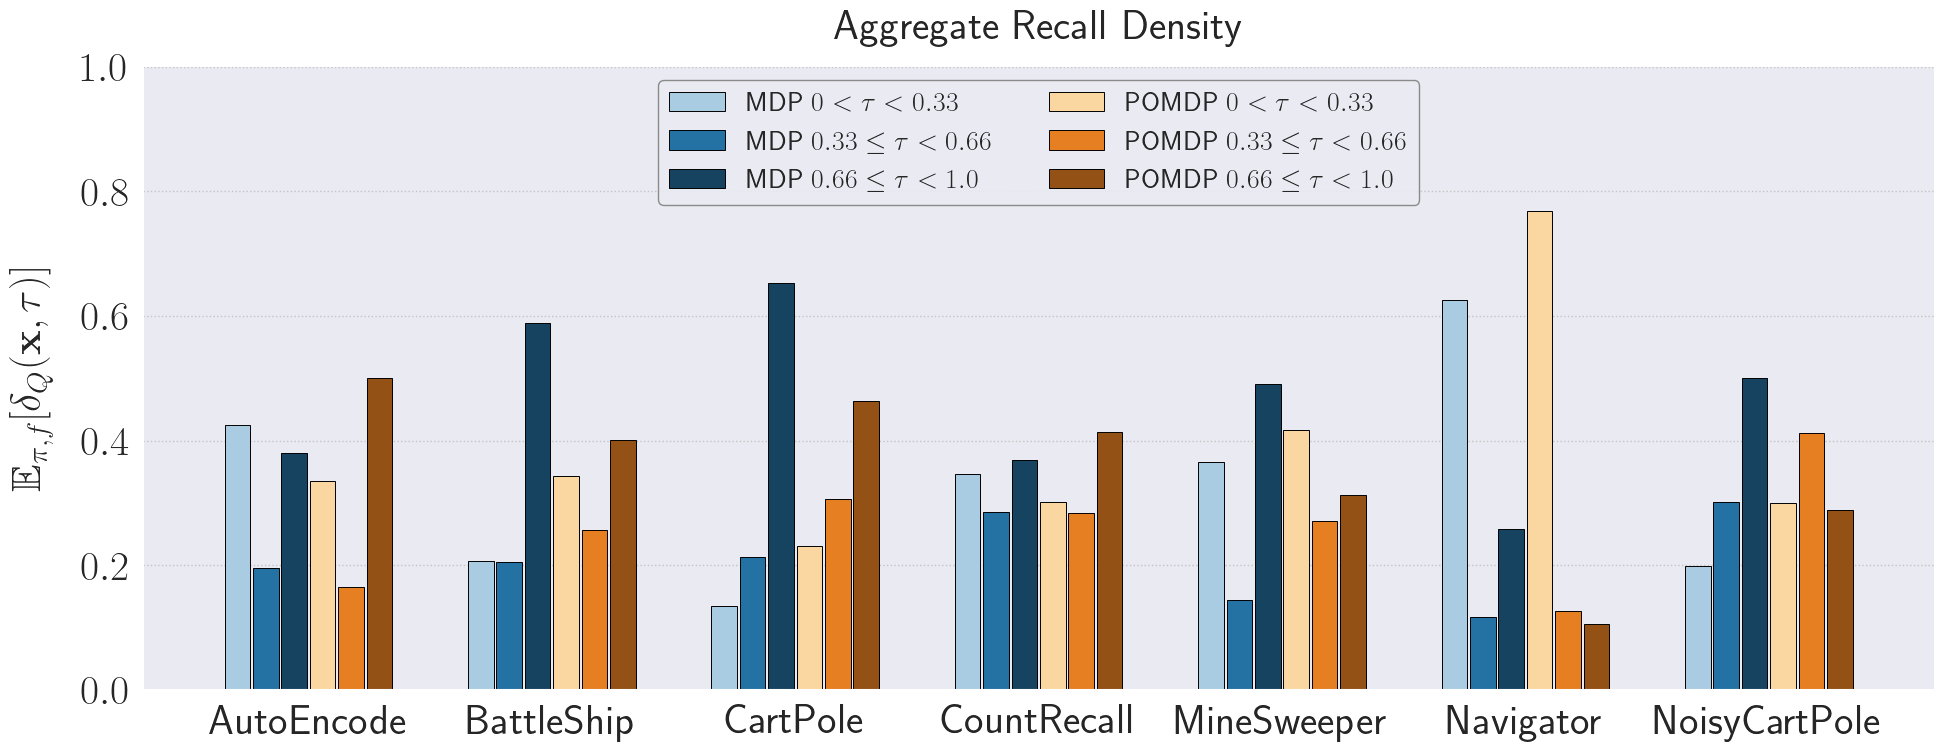

In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from matplotlib.patches import Patch

# Set style
sns.set_style("darkgrid")
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}'
plt.rcParams['axes.linewidth'] = 1.2

# Model list
MODEL_TYPES = ["fart", "mingru", "lru"]
print("Start aggregating all model data...")

# Function: extract model type, environment and partial observation from filename
def extract_info_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.replace('saliency_results_', '').replace('.csv', '').split('_')
    model_type_from_file = parts[0]
    env_name = parts[1]
    partial_obs_str = parts[2].split('=')[1]
    return model_type_from_file, env_name, partial_obs_str

# Collect all model data
all_results = []

for model_type in MODEL_TYPES:
    csv_files = glob.glob(f"gradientdata/saliency_results_{model_type}_*.csv")

    for csv_file in csv_files:
        try:
            model_type_in_filename, env_name, partial_obs_str = extract_info_from_filename(csv_file)

            df = pd.read_csv(csv_file)
            pos_cols = [col for col in df.columns if col.startswith('pos_')]

            if not pos_cols or len(df[pos_cols].mean().values) < 3:
                continue

            means_all_positions = df[pos_cols].mean().values
            num_positions = len(means_all_positions)

            early_mean_raw = np.mean(means_all_positions[:num_positions//3])
            mid_mean_raw = np.mean(means_all_positions[num_positions//3 : 2*num_positions//3])
            late_mean_raw = np.mean(means_all_positions[2*num_positions//3:])

            total_mean = early_mean_raw + mid_mean_raw + late_mean_raw
            if total_mean == 0:
                early_mean_normalized = 0
                mid_mean_normalized = 0
                late_mean_normalized = 0
            else:
                early_mean_normalized = early_mean_raw / total_mean
                mid_mean_normalized = mid_mean_raw / total_mean
                late_mean_normalized = late_mean_raw / total_mean

            all_results.append({
                'model_type': model_type_in_filename,
                'env_name': env_name,
                'partial_obs': partial_obs_str,
                'n_seeds': len(df),
                'early_mean': early_mean_normalized,
                'mid_mean': mid_mean_normalized,
                'late_mean': late_mean_normalized
            })

        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")

# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)

if all_results_df.empty:
    print("No data collected. Please check if CSV files exist.")
else:
    # Group by environment and partial observation and compute the average for all models
    aggregated_results = all_results_df.groupby(['env_name', 'partial_obs']).agg({
        'early_mean': 'mean',
        'mid_mean': 'mean',
        'late_mean': 'mean',
        'n_seeds': 'sum'  # Total sample size
    }).reset_index()

    print(f"Aggregated {len(all_results_df)} results covering {len(aggregated_results)} environment-observation combinations")

    # Create plot
    unique_envs = aggregated_results['env_name'].unique()
    fig_width_val = max(15, len(unique_envs) * 2.8)
    fig_height_val = 8

    fig, ax = plt.subplots(figsize=(fig_width_val, fig_height_val))

    env_names = sorted(unique_envs)

    time_keys = ['early', 'mid', 'late']
    time_positions_display = {
        'early': r"$0 < \tau < 0.33$",
        'mid': r"$0.33 \leq \tau < 0.66$",
        'late': r"$0.66 \leq \tau < 1.0$"
    }
    n_time_pos = len(time_keys)

    n_envs = len(env_names)
    n_groups = 2

    total_env_width = 0.7
    group_width = total_env_width / n_groups
    bar_width = group_width / n_time_pos

    # Color definitions
    mdp_early_color = '#A9CCE3'
    mdp_mid_color = '#2471A3'
    mdp_late_color = '#154360'
    pomdp_early_color = '#FAD7A0'
    pomdp_mid_color = '#E67E22'
    pomdp_late_color = '#935116'

    mdp_color_map = {
        'early': mdp_early_color,
        'mid': mdp_mid_color,
        'late': mdp_late_color
    }
    pomdp_color_map = {
        'early': pomdp_early_color,
        'mid': pomdp_mid_color,
        'late': pomdp_late_color
    }

    x_base_pos = np.arange(n_envs)
    legend_handles_for_this_plot = {}

    for env_idx, env_name in enumerate(env_names):
        for group_idx, partial_setting in enumerate(['False', 'True']):
            subset = aggregated_results[
                (aggregated_results['env_name'] == env_name) &
                (aggregated_results['partial_obs'] == partial_setting)
            ]

            if subset.empty:
                continue

            for time_idx, time_key in enumerate(time_keys):
                mean_col = f'{time_key}_mean'
                group_center_offset = (group_idx - 0.5) * group_width
                time_pos_offset = (time_idx - (n_time_pos - 1) / 2) * bar_width
                bar_exact_pos = x_base_pos[env_idx] + group_center_offset + time_pos_offset

                if partial_setting == 'False':
                    color = mdp_color_map[time_key]
                    condition_label = 'MDP'
                else:
                    color = pomdp_color_map[time_key]
                    condition_label = 'POMDP'

                legend_label_key = f'{condition_label} {time_positions_display[time_key]}'

                bar = ax.bar(
                    bar_exact_pos,
                    subset[mean_col].values[0],
                    bar_width * 0.9,
                    color=color,
                    edgecolor='black',
                    linewidth=0.7,
                )
                if legend_label_key not in legend_handles_for_this_plot:
                    legend_handles_for_this_plot[legend_label_key] = bar[0]

    ax.set_title(r'Aggregate Recall Density', fontsize=30, pad=20, loc='center')
    ax.set_ylabel(r'$\mathbb{E}_{\pi, f}[\delta_Q(\mathbf{x}, \tau)]$', fontsize=30, labelpad=20)

    ax.set_xticks(x_base_pos)
    cleaned_env_names = [name.replace('Easy', '') for name in env_names]
    ax.set_xticklabels(cleaned_env_names, rotation=0, ha='center', fontsize=30)
    ax.tick_params(axis='x', pad=5)  # Adjust x-axis tick label distance to x-axis

    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.arange(0, 1.1, 0.2))

    ordered_legend_labels = []
    for time_key in time_keys:
        ordered_legend_labels.append(f'MDP {time_positions_display[time_key]}')
    for time_key in time_keys:
        ordered_legend_labels.append(f'POMDP {time_positions_display[time_key]}')

    final_legend_handles = []
    final_legend_labels = []
    for lbl in ordered_legend_labels:
        if lbl in legend_handles_for_this_plot:
            final_legend_handles.append(legend_handles_for_this_plot[lbl])
            final_legend_labels.append(lbl)

    if final_legend_handles:
        legend = ax.legend(final_legend_handles, final_legend_labels,
                          loc='upper center',
                          ncol=2,
                          fontsize=20,
                          frameon=True,
                          framealpha=0.9,
                          edgecolor='grey')

    ax.grid(True, axis='y', linestyle=':', color='darkgrey', alpha=0.6)
    ax.grid(False, axis='x')

    sns.despine(left=False, bottom=False, top=True, right=True)

    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save as PDF
    # output_filename_pdf = '../../popgym_arcade_plot/recall_density_aggregate_all_models.pdf'
    # plt.savefig(output_filename_pdf, dpi=300, bbox_inches='tight', format='pdf')
    # plt.show()
    # print(f"Figure saved as: {output_filename_pdf}")

    # Save aggregated results
    # summary_filename = '../../popgym_arcade_plot/summary_recall_density_aggregate.csv'
    # aggregated_results.to_csv(summary_filename, index=False, float_format='%.4f')
    # print(f"Aggregated results saved as: {summary_filename}")

print("\n--- Process complete ---")